In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import ast


In [2]:
import os

# List everything inside /kaggle/input
print(os.listdir("/kaggle/input"))

['recommendation-dataset']


In [3]:
print(os.listdir("/kaggle/input/recommendation-dataset"))  # replace with the name you saw above

['cleaned_data.csv', 'data_by_year.csv', 'data_by_genres.csv', 'data_w_genres.csv', 'data_by_artist.csv', 'data.csv']


# Step 1.1: load main data

In [4]:
# Step 1.1: Load the main data
df = pd.read_csv('/kaggle/input/recommendation-dataset/data.csv')
df.head()


,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


Step 1.2: load genres data and merge

In [5]:
genres_df = pd.read_csv('/kaggle/input/recommendation-dataset/data_w_genres.csv')

# Safely convert the 'artists' column from string representation of list → real list
def safe_literal_eval(x):
    if pd.isna(x):
        return []                                      # missing → empty list
    try:
        return ast.literal_eval(x)                     # works when it's "['a', 'b']"
    except (ValueError, SyntaxError):
        # Some rows have malformed strings like "\"Cats\" 1981 Original London Cast"
        # → clean double quotes and try again, otherwise return single-item list
        cleaned = str(x).replace('"', "'").strip()
        if cleaned.startswith("[") and cleaned.endswith("]"):
            try:
                return ast.literal_eval(cleaned)
            except:
                pass
        # fallback: treat the whole string as one artist name
        return [str(x).strip().strip('"').strip("'")]

genres_df['artists'] = genres_df['artists'].apply(safe_literal_eval)

In [6]:
genres_exploded = genres_df.explode('artists').reset_index(drop=True)

# Optional: drop rows where artist is NaN after exploding
genres_exploded = genres_exploded.dropna(subset=['artists'])

print(genres_exploded.head())
print("Total artist→genres mappings:", len(genres_exploded))

           genres                                            artists  \
0  ['show tunes']                    Cats" 1981 Original London Cast   
1              []                           Cats" 1983 Broadway Cast   
2              []         Fiddler On The Roof” Motion Picture Chorus   
3              []      Fiddler On The Roof” Motion Picture Orchestra   
4              []  Joseph And The Amazing Technicolor Dreamcoat" ...   

   acousticness  danceability    duration_ms    energy  instrumentalness  \
0      0.590111      0.467222  250318.555556  0.394003          0.011400   
1      0.862538      0.441731  287280.000000  0.406808          0.081158   
2      0.856571      0.348286  328920.000000  0.286571          0.024593   
3      0.884926      0.425074  262890.962963  0.245770          0.073587   
4      0.510714      0.467143  270436.142857  0.488286          0.009400   

   liveness   loudness  speechiness       tempo   valence  popularity  key  \
0  0.290833 -14.448000     0.210

In [7]:
# Convert artists column in main data.csv the same way
df = pd.read_csv('/kaggle/input/recommendation-dataset/data.csv')
df['artists'] = df['artists'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Explode both so we can merge on single artist name
df_exploded = df.explode('artists')

# Merge genres
df_with_genres = pd.merge(
    df_exploded,
    genres_exploded[['artists', 'genres']],
    on='artists',
    how='left'
)

# If a song has multiple artists → multiple rows → aggregate genres back into list
df = df_with_genres.groupby(df_with_genres.index).agg({
    'id': 'first',
    'name': 'first',
    'artists': 'first',
    'year': 'first',
    'popularity': 'first',
    'danceability': 'first',
    'energy': 'first',
    'valence': 'first',
    'tempo': 'first',
    'loudness': 'first',
    'acousticness': 'first',
    'instrumentalness': 'first',
    'liveness': 'first',
    'speechiness': 'first',
    'duration_ms': 'first',
    'explicit': 'first',
    'key': 'first',
    'mode': 'first',
    # collect all genres from all artists of the song
    'genres': lambda x: list(set(sum([g for g in x if isinstance(g, list)], [])))
}).reset_index(drop=True)


In [8]:
# Step 1.3: Handle missing values (drop rows missing key audio features)
df.dropna(subset=['danceability', 'energy', 'valence', 'genres'], inplace=True)

# Step 1.4: Remove duplicates based on song ID
df.drop_duplicates(subset=['id'], inplace=True)

# Step 1.5: Normalize numerical audio features
numerical_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                  'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'key']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [9]:
# Clean artists into a single string (no genres)
def clean_artists(x):
    if isinstance(x, list):
        return " ".join(x)
    return str(x)

df["artists_clean"] = df["artists"].apply(clean_artists)

# Text feature = artists + song name ONLY
df["text"] = df["artists_clean"].fillna("") + " " + df["name"].fillna("")

# Save cleaned data for later use
df.to_csv("cleaned_data.csv", index=False)
print("Data cleaned and saved. Shape:", df.shape)


Data cleaned and saved. Shape: (170653, 21)


# EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


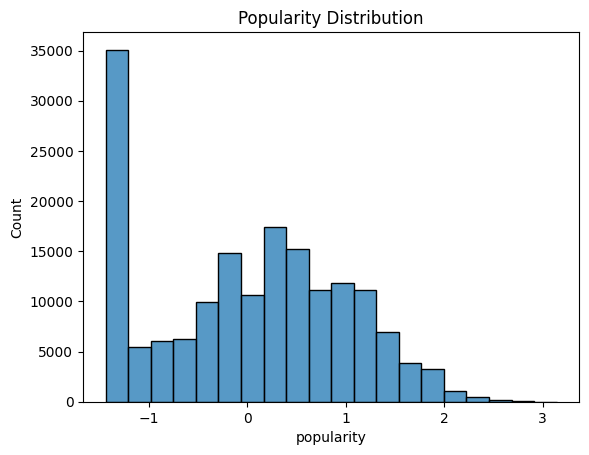

In [10]:
# Step 2.1: Distributions (e.g., popularity)
sns.histplot(df['popularity'], bins=20)
plt.title('Popularity Distribution')
plt.show()

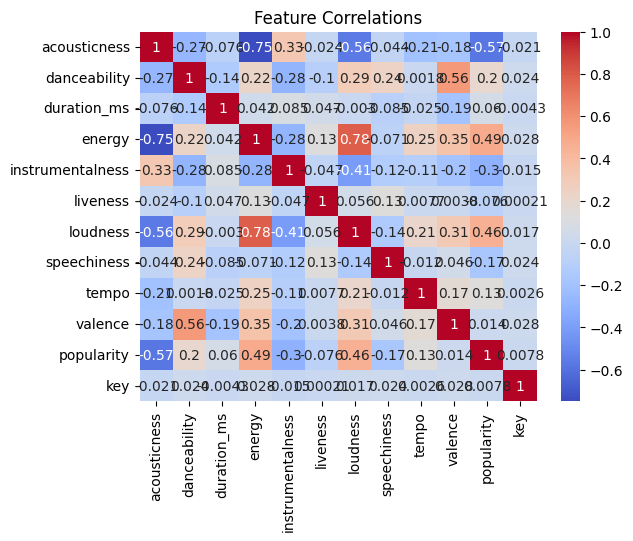

In [11]:
# Step 2.2: Correlations heatmap
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

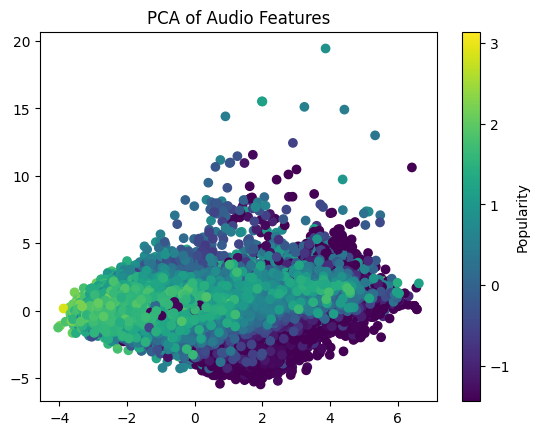

In [12]:
# Step 2.3: PCA visualization (reduce to 2D)
features = df[numerical_cols]
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df['popularity'], cmap='viridis')
plt.colorbar(label='Popularity')
plt.title('PCA of Audio Features')
plt.show()

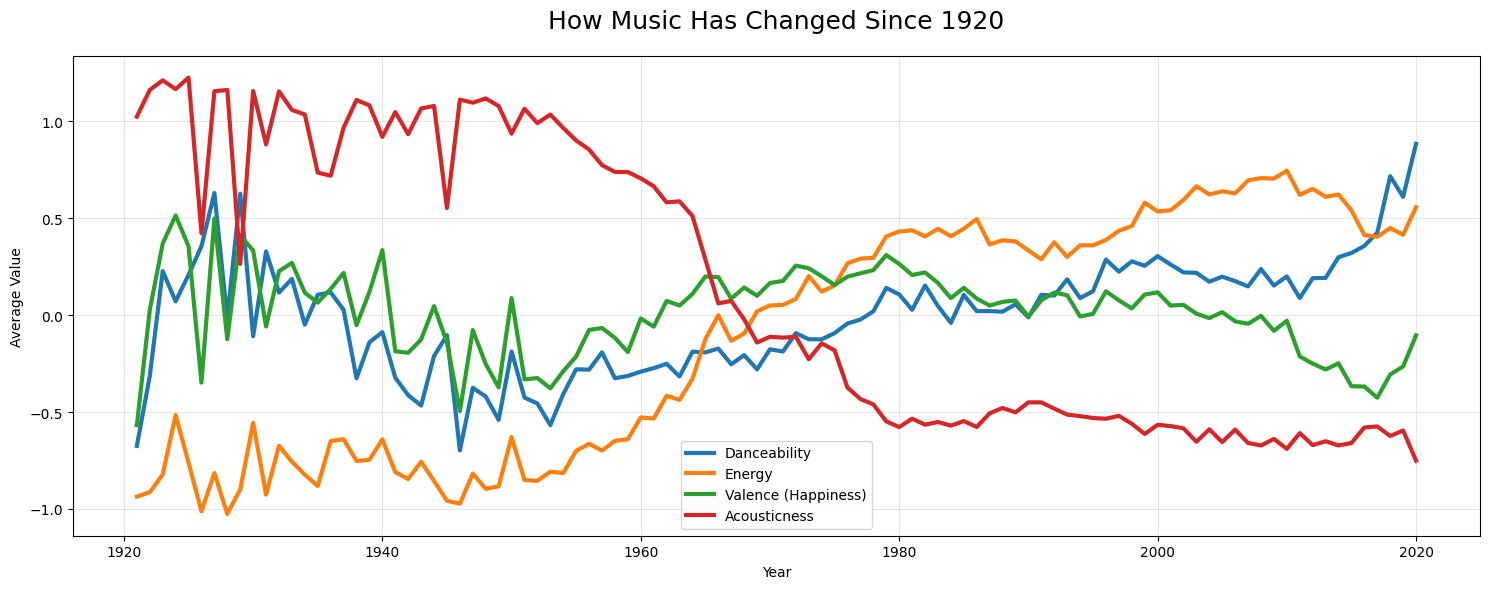

In [13]:
# 1. Evolution of Music Taste Over 100 Years
plt.figure(figsize=(15, 6))
year_means = df.groupby('year')[['danceability','energy','valence','acousticness','loudness']].mean()
plt.plot(year_means.index, year_means['danceability'], label='Danceability', lw=3)
plt.plot(year_means.index, year_means['energy'], label='Energy', lw=3)
plt.plot(year_means.index, year_means['valence'], label='Valence (Happiness)', lw=3)
plt.plot(year_means.index, year_means['acousticness'], label='Acousticness', lw=3)
plt.title('How Music Has Changed Since 1920', fontsize=18, pad=20)
plt.xlabel('Year'), plt.ylabel('Average Value')
plt.legend(), plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Step 2.4: Feature importance (mutual info with popularity)
mi_scores = mutual_info_regression(features.drop('popularity', axis=1), features['popularity'])
mi_df = pd.DataFrame({'Feature': features.drop('popularity', axis=1).columns, 'MI Score': mi_scores})
print(mi_df.sort_values('MI Score', ascending=False))

             Feature  MI Score
0       acousticness  0.263246
6           loudness  0.159309
3             energy  0.158819
2        duration_ms  0.100464
8              tempo  0.077014
7        speechiness  0.071163
4   instrumentalness  0.066606
1       danceability  0.032492
5           liveness  0.018005
10               key  0.013440
9            valence  0.010254


# Feature Engineering

In [15]:
# Step 3.1: Audio features vector
audio_features = df[numerical_cols].drop('popularity', axis=1)  # Exclude popularity for now

# Step 3.2: TF-IDF on text (artists + name + genres)
tfidf = TfidfVectorizer(max_features=5000)  # Limit features to avoid sparsity
tfidf_matrix = tfidf.fit_transform(df['text'])

# Step 3.3: Popularity weight (we'll use it in hybrid similarity later)

# Step 3.4: Clusters (KMeans on audio features for optional grouping)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(audio_features)

# Build Similarity Matrix

In [16]:
# =====================================================
# FINAL CLEAN VERSION – Works with your exact data (no 'genres' needed)
# =====================================================

from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

print("Building final recommender using available data only...")

# ---- Step 1: Clean artists and build text field (artist + song name) ----
def clean_artists(x):
    x = str(x)
    # If it looks like "['A', 'B']" just strip brackets/quotes
    if x.startswith('[') and ']' in x:
        x = x.replace('[', '').replace(']', '').replace("'", "")
    return x

df['artists_clean'] = df['artists'].apply(clean_artists)

df['text'] = (
    df['artists_clean'].fillna('') + ' ' +
    df['name'].astype(str)
)

# ---- Step 2: Select audio features (assumed already scaled earlier) ----
audio_features = [
    'danceability', 'energy', 'valence', 'loudness',
    'acousticness', 'instrumentalness', 'speechiness',
    'liveness', 'tempo'
]

audio_matrix = df[audio_features].values.astype(np.float32)

# ---- Step 3: TF‑IDF on artist + title ----
tfidf = TfidfVectorizer(
    max_features=2500,
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2)
)
text_matrix = tfidf.fit_transform(df['text'])

# ---- Step 4: Popularity (numeric feature) ----
popularity = df['popularity'].values.reshape(-1, 1).astype(np.float32)

# ---- Step 5: Final hybrid matrix — 65% audio + 30% text + 5% popularity ----
print("Combining features...")
X = hstack([
    csr_matrix(audio_matrix) * 0.65,
    text_matrix * 0.30,
    csr_matrix(popularity) * 0.05
]).tocsr().astype(np.float32)

print(f"Feature matrix ready: {X.shape[0]:,} songs × {X.shape[1]} dimensions")


Building final recommender using available data only...
Combining features...
Feature matrix ready: 170,653 songs × 2510 dimensions


In [17]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 71.8 MB/s eta 0:00:00


In [18]:
import faiss
from scipy.sparse import csr_matrix
import joblib

# Convert sparse to dense
X_dense = X.toarray().astype('float32')

# Normalize (cosine-style search)
faiss.normalize_L2(X_dense)

d = X_dense.shape[1]
index = faiss.IndexFlatIP(d)
index.add(X_dense)

print("FAISS index size:", index.ntotal)

# SAVE everything
faiss.write_index(index, "faiss_music.index")
df.to_csv("cleaned_data_for_app.csv", index=False)
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(audio_features, "audio_features_list.joblib")  # if you need it


FAISS index size: 170653


['audio_features_list.joblib']

In [19]:
import os
os.listdir(".")

['__notebook__.ipynb',
 'faiss_music.index',
 'tfidf_vectorizer.joblib',
 'cleaned_data.csv',
 'audio_features_list.joblib',
 'cleaned_data_for_app.csv']